In [168]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [169]:
channel = 0

In [170]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [171]:
"""  PATH = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_Cs.root'
#PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare


#noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale
noise_file = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_X.root'
RunNoise = uproot.open(noise_file)  #Apertura rumore """

"  PATH = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_Cs.root'\n#PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare\nRunCs = uproot.open(PATH) #Apertura file da analizzare\n\n\n#noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale\nnoise_file = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_X.root'\nRunNoise = uproot.open(noise_file)  #Apertura rumore "

In [172]:
PATH = '../Dati/27_03/Run_ch0_Cs_Measurements_Only_4_3_2024_0000.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch4_Cs_Measurements_Only_4_21_2024_0000.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch7_Cs_Measurements_Only_3_27_2024_0000.root' #Percorso relativo del file da analizzare


RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [173]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [174]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 0 = 906223
#Noise ripulita su ch 0 = 246046


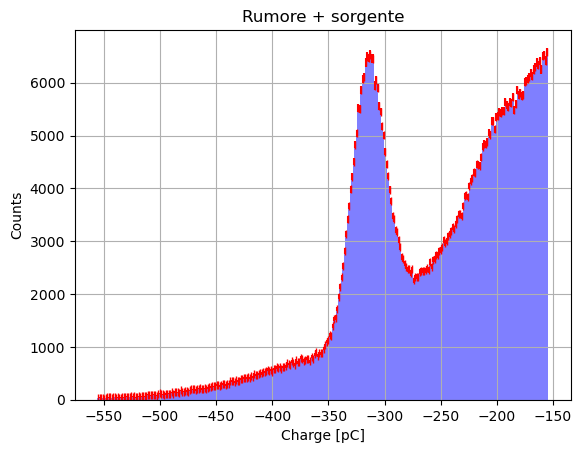

In [175]:
Nbin = 300
bin_lims = [int(Nbin *45 / 100), int(Nbin * 87 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


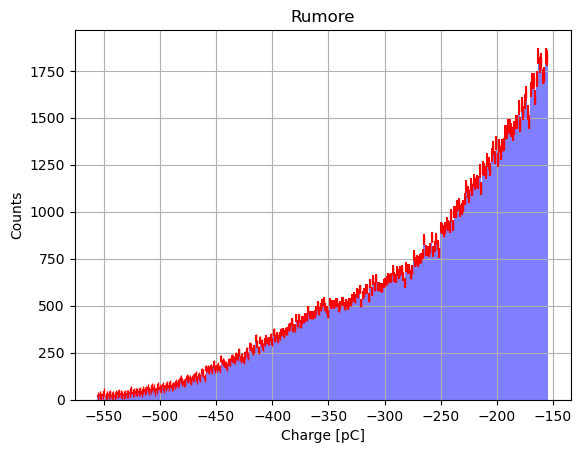

172661.0

In [176]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [177]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

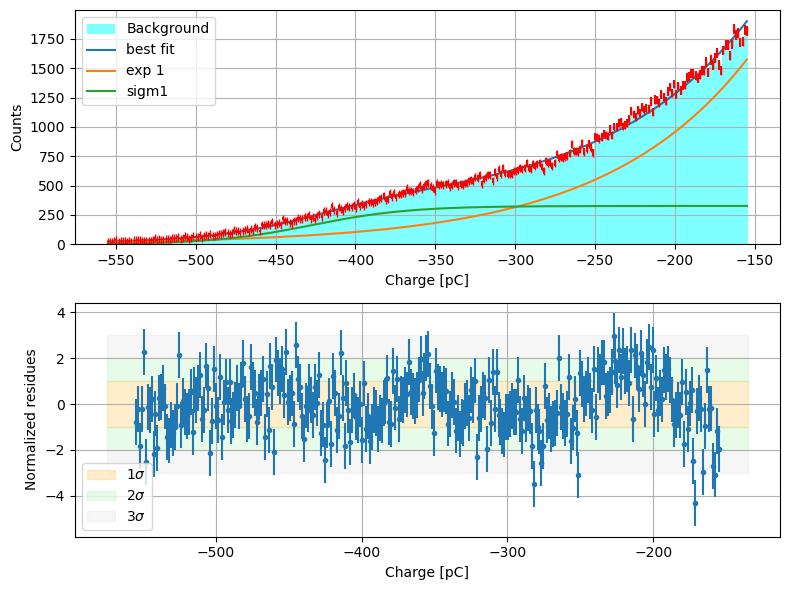

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 300
    # variables        = 5
    chi-square         = 431.332591
    reduced chi-square = 1.46214437
    Akaike info crit   = 118.929097
    Bayesian info crit = 137.448009
    R-squared          = 0.99999393
[[Variables]]
    e1_amplitude:  8761.34661 +/- 327.911773 (3.74%) (init = 12246.84)
    e1_decay:     -90.2876440 +/- 2.27440467 (2.52%) (init = -98.87599)
    s1_amplitude:  326.156766 +/- 18.3477097 (5.63%) (init = 1814)
    s1_center:    -427.204247 +/- 1.89063404 (0.44%) (init = -354.9759)
    s1_sigma:      30.4269988 +/- 1.88713836 (6.20%) (init = 57.14961)
    g2_amplitude:  0 (fixed)
    g2_center:    -320 (fixed)
    g2_sigma:      25 (fixed)
    g2_fwhm:       58.8705000 +/- 0.00000000 (0.00%

In [178]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid.guess(binN, x=centersN))   #Indovina i parametri della sigmoide
#params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(sigmoid2.make_params(amplitude = 0, center = -320, sigma = 25))
#params.update(fd1.make_params(amplitude = 0, center = -200, kt = -15))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
#params.update(sigmoid.make_params(amplitude = 0, center = -200, sigma = 50))

#params["g1_amplitude"].min = 500
params["e1_amplitude"].min = 0

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

model = exp1  + gauss2 + sigmoid + sigmoid2   #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='sigm1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [179]:
params.update(result.params)
params

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,8761.34661,327.911773,(3.74%),12246.841726392382,0.00000000,inf,True,
e1_decay,-90.2876440,2.27440467,(2.52%),-98.8759909039529,-inf,inf,True,
s1_amplitude,326.156766,18.3477097,(5.63%),1814.0,-inf,inf,True,
s1_center,-427.204247,1.89063404,(0.44%),-354.9758605957031,-inf,inf,True,
s1_sigma,30.4269988,1.88713836,(6.20%),57.149605887276785,0.00000000,inf,True,
g2_amplitude,0.00000000,0.00000000,,0.0,-inf,inf,False,
g2_center,-320.000000,0.00000000,(0.00%),-320.0,-inf,inf,False,
g2_sigma,25.0000000,0.00000000,(0.00%),25.0,0.00000000,inf,False,
g2_fwhm,58.8705000,0.00000000,(0.00%),58.87050000000001,-inf,inf,False,2.3548200*g2_sigma
g2_height,0.00000000,0.00000000,,0.0,-inf,inf,False,"0.3989423*g2_amplitude/max(1e-15, g2_sigma)"


In [180]:
N_comp_ratio = float(params["e1_amplitude"].value / params["s1_amplitude"].value)
print(N_comp_ratio)

26.862378879170805


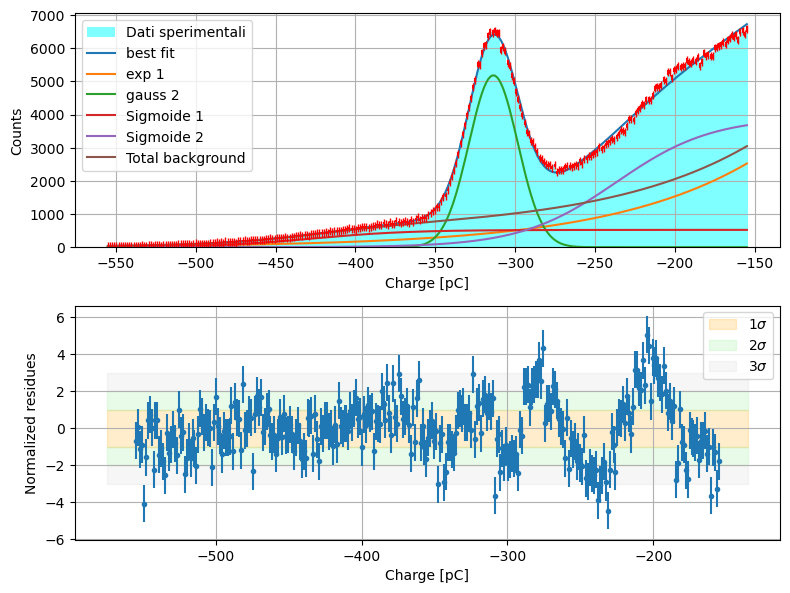

In [181]:
#fisso rapporto tra le ampiezze
params.add("ratio", value = N_comp_ratio)
#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False
params["ratio"].vary = False
params["s1_amplitude"].value = 100

#params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima fermi-dirac
#params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False
params["s1_amplitude"].vary = True
params["s1_center"].vary = False
params["s1_sigma"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di seconda Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True
params["s2_amplitude"].vary = True
params["s2_center"].vary = True
params["s2_sigma"].vary = True




params["e1_amplitude"].value = 180000
#params["g1_amplitude"].value = 748294

params["g2_amplitude"].value = 5000     #Parametri da aggiustare to make the magic happen
params["g2_amplitude"].min = 5000 
params["g2_center"].min = -340         #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -290
params["g2_center"].set(value = -310)
params["g2_sigma"].set(value = 0.5)

params["s2_amplitude"].set(value = 500)
#params["s2_amplitude"].min = 0
#params["s2_amplitude"].vary = False
params["s2_center"].set(value = -250)
params["s2_sigma"].set(value = 1)
params["s2_sigma"].min = 1
params["s2_center"].min = -300
params["s2_center"].max = -100

params.update(params)


# Fit the model to the data
result = model.fit(binCs, params, x = centersCs, weights = 1 / errCs)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, result.best_fit, label='best fit')
ax1.plot(centersCs, comps['e1_'], label='exp 1')
#ax1.plot(centersCs, comps['g1_'], label='gauss 1')
ax1.plot(centersCs, comps['g2_'], label='gauss 2')
ax1.plot(centersCs, comps['s1_'], label='Sigmoide 1')
ax1.plot(centersCs, comps['s2_'], label='Sigmoide 2')
ax1.plot(centersCs, comps['e1_'] + comps['s1_'], label='Total background')



ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueCs = binCs - result.best_fit
norm_resCs = residueCs / errCs

ax2.errorbar(centersCs, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
#print(result.fit_report())



# Print fit statistics and parameter values
#print(result.fit_report())



In [182]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 274
    # data points      = 300
    # variables        = 7
    chi-square         = 770.612763
    reduced chi-square = 2.63007769
    Akaike info crit   = 297.021056
    Bayesian info crit = 322.947533
    R-squared          = 0.99999948
[[Variables]]
    e1_amplitude:  14047.2153 +/- 143.478341 (1.02%) == 's1_amplitude * ratio'
    e1_decay:     -90.28764 (fixed)
    s1_amplitude:  522.932660 +/- 5.34123736 (1.02%) (init = 100)
    s1_center:    -427.2042 (fixed)
    s1_sigma:      30.427 (fixed)
    g2_amplitude:  198495.942 +/- 1587.92279 (0.80%) (init = 5000)
    g2_center:    -313.652086 +/- 0.09867247 (0.03%) (init = -310)
    g2_sigma:      15.2752071 +/- 0.10354823 (0.68%) (init = 0.5)
    g2_fwhm:       35.9703632 +/- 0.2438374

def gauss(x, m, s):
    return 1 / np.sqrt((np.pi * 2) * s) * np.exp(-(x - m)**2 / (2 * s**2))

norm = float(len(norm_resCs))
bin_res_norm, edg_res_norm, _ = plt.hist(norm_resCs, bins = 9, density = True)
res_norm_cnt = np.convolve(edg_res_norm, [0.5, 0.5], "valid")
plt.errorbar(res_norm_cnt, bin_res_norm, np.sqrt(bin_res_norm * norm) / norm, ls = "")
norm_res_mean = res_norm_cnt.mean()
norm_res_std  = res_norm_cnt.std()

rng_gauss = np.arange(edg_res_norm[0], edg_res_norm[-1], 0.1)
best_gauss = gauss(rng_gauss, norm_res_mean, norm_res_std)

plt.plot(rng_gauss, best_gauss)